### Задание 3
У вас есть архив с данными по производству электроэнергии ветряными мельницами в Германии. Вам необходимо исследовать временной ряд, описать 
основные статистики для временного ряда, сделать вывод по временному ряду и сформировать исследовательский отчет подкрепленный 
соответствующими выводами. 
Необходимо выбрать модель для прогноза временного ряда, объяснить почему именно была выбрана данная модель, объяснить на каком основании. 
Сделайте прогноз по производству электроэнергии на 1 год вперед, измерить метрику качества.

----

### Решение

Импортируем необходимые библиотеки

In [46]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import shapiro, kstest, normaltest
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import normal_ad
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')

#### 1. Изучение временного ряда

Загрузим датасет и изучим его

In [47]:
df = pd.read_csv('data.csv', parse_dates=['dt'])
df.columns = ["ds", "y"]

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385566 entries, 0 to 385565
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   ds      385566 non-null  datetime64[ns]
 1   y       385566 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.9 MB


In [49]:
df.head()

,ds,y
0,2011-01-01 00:00:00,3416.0
1,2011-01-01 00:15:00,4755.0
2,2011-01-01 00:30:00,4939.0
3,2011-01-01 00:45:00,4939.0
4,2011-01-01 01:00:00,4998.0


Изучим данные. Отмечаем, что целевая переменная варьирует в диапазоне от 0 до 16727 при среднем значении 3184 и 75 % процентиле, равном 4530. Это свидетельствует о том, что данные сильно сдвинуты вправо. Стандартное отклонение, практически равное среднему значению, указывает на значительные колебания данных.

In [50]:
df["y"].describe()

count    385566.000000
mean       3183.560481
std        3045.941591
min           0.000000
25%         905.000000
50%        2164.000000
75%        4529.877500
max       16727.500000
Name: y, dtype: float64

Отмечаем, что датасет не содержит выпадающих значений. Данные приведены с 15-минутным интервалом. Такая частотность кажется избыточной, поскольку может генерировать значительный объем шума. Кроме того, данные порядка 5-10 тыс. приведены в формате float, что кажется избыточным. Позже будут внесены соответствующие изменения.

Визуализируем часть временного ряда. Отмечаем значительные колебания целевой переменной, в диапазоне от 0 до 16000.

<Axes: >

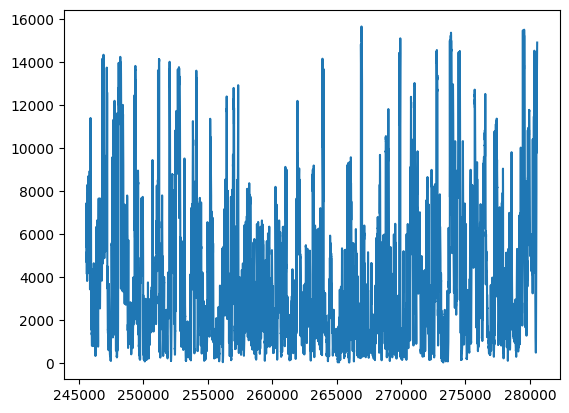

In [51]:
df["y"][-140000:-105000].plot()

Как упоминалось выше, 15-минутные интервалы данных кажутся избыточными. Преобразуем эти интервалы в часовые, усреднив значения. После этого преобразуем формат данных

In [52]:
data_hourly = df.resample("h", on="ds").mean().reset_index().dropna()
data_hourly['y'] = data_hourly['y'].astype(int)
data_hourly.tail()

,ds,y
96387,2021-12-30 03:00:00,6274
96388,2021-12-30 04:00:00,6865
96389,2021-12-30 05:00:00,7829
96390,2021-12-30 06:00:00,8421
96391,2021-12-30 07:00:00,8368


Выполним проверку, что все данные 

In [53]:
if (data_hourly['y'] >= 0).all:
    print("Все значения больше нуля: ", True)

Все значения больше нуля:  True


Отмечаем, что сформированный датасет содержит в 4 раза меньше данных. Данные в столбце "y" имеют формат int.

In [54]:
data_hourly.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96381 entries, 0 to 96391
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      96381 non-null  datetime64[ns]
 1   y       96381 non-null  int32         
dtypes: datetime64[ns](1), int32(1)
memory usage: 1.8 MB


Выполним визуализацию данных. Для этого используем функцию values_distribution

In [55]:
def values_distribution(df):
    plt.figure(figsize=(10, 4))
    sns.histplot(df, kde=True, bins=50)
    plt.title('Распределение данных в датасете')
    plt.xlabel('Величина мощности')
    plt.ylabel('Частота')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

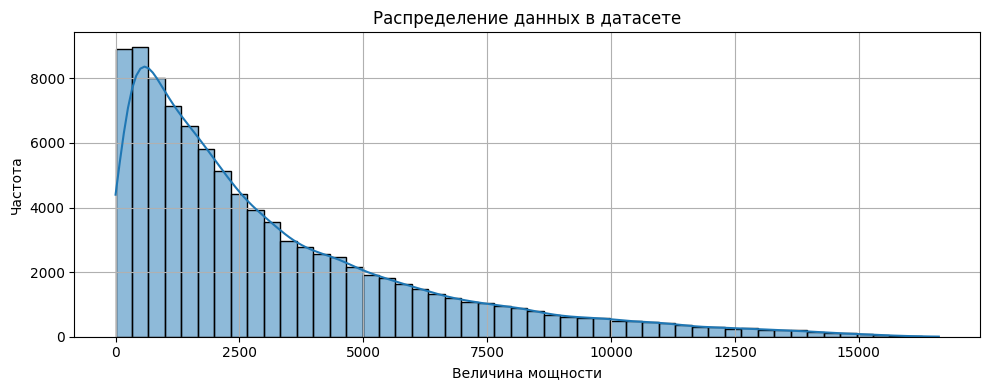

In [56]:
values_distribution(data_hourly["y"])

Отмечаем, что распределение данных не соответствует нормальному. Это, скорее, логарифмическое распределение. Поэтому там потребуется преобразование данных впоследствии для работы с ними.

На основе диаграммы мы предположили, что данные распределены не нормально. Проверим это утверждение с помощью статистических критериев нормальности.

In [57]:
def is_normal(test, p_level=0.05):
    stat, pval = test
    return 'Normal' if pval > p_level else 'Not Normal'

def normality_tests(df):
    normal_args = (np.mean(df), np.std(df))

    # 1. Тест Шапиро–Уилка
    print(f"Checking normality with Shapiro-Wilk test: {is_normal(shapiro(df))}")  

    # 2. Тест Д’Агостино и Пирсона (normaltest)
    print(f"Checking normality with D'Agostino-Pearson test: {is_normal(normaltest(df))}")  

    # 3. Тест Андерсона-Дарлинга (из пакета statsmodels)
    print(f"Checking normality with Anderson-Darling test: {is_normal(normal_ad(df))}")  

    # 5. Критерий Колмогорова–Смирнова против нормального распределения с параметрами, оценёнными из данных
    print(f"Checking normality with Kolmogorov-Smirnov test: {is_normal(kstest(df,
                       cdf='norm',
                       args=normal_args))}")

In [58]:
normality_tests(data_hourly["y"])

Checking normality with Shapiro-Wilk test: Not Normal
Checking normality with D'Agostino-Pearson test: Not Normal
Checking normality with Anderson-Darling test: Not Normal
Checking normality with Kolmogorov-Smirnov test: Not Normal


Как и предполагалось, данные распределены не нормально. Об этом же свидетельствует и QQ-диаграмма

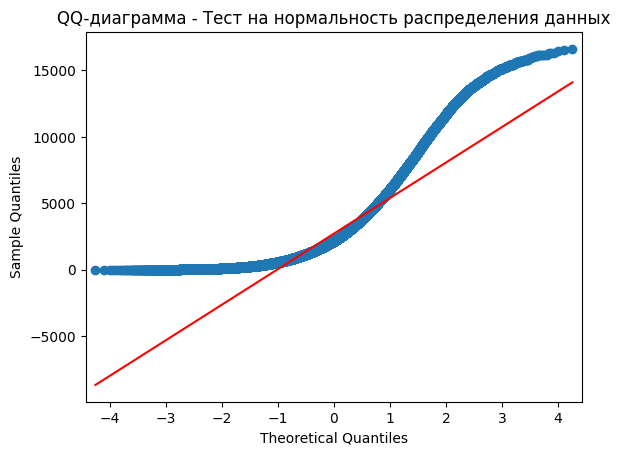

In [59]:
qqplot(data_hourly["y"], line='q')
plt.title("QQ-диаграмма - Тест на нормальность распределения данных");

Проверим временной ряд на стационарность. Стационарность является важным условием для использования многих библиотек для работы с временными рядами

In [60]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test

        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

Results of Dickey-Fuller Test:
Test Statistic                   -24.734196
p-value                            0.000000
#Lags Used                        64.000000
Number of Observations Used    96316.000000
Critical Value (1%)               -3.430418
Critical Value (5%)               -2.861570
Critical Value (10%)              -2.566786
dtype: float64


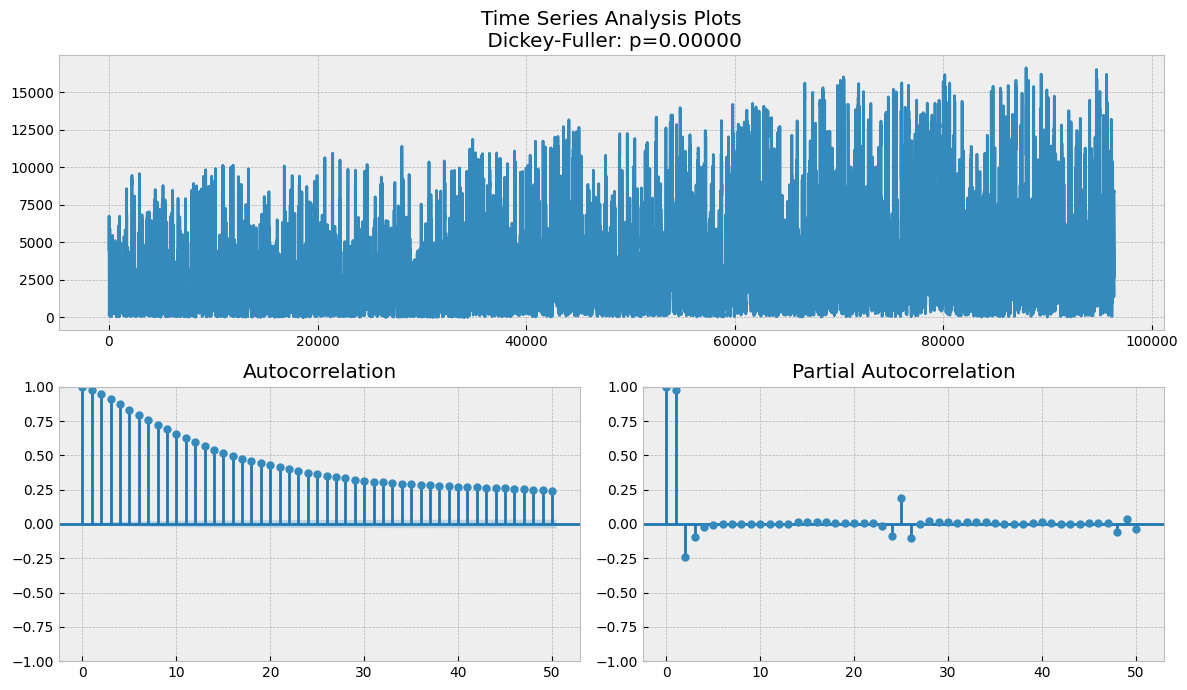

In [61]:
test_stationarity(data_hourly["y"])
tsplot(data_hourly["y"])

Отмечаем, что уже без преобразования ряд является стационарным, исходя из критерия Дики-Фуллера. Однако наблюдается выраженная сезонность. Поэтому проведем дифференцирование ряда на 1 лаг.

Results of Dickey-Fuller Test:
Test Statistic                   -52.997972
p-value                            0.000000
#Lags Used                        67.000000
Number of Observations Used    96312.000000
Critical Value (1%)               -3.430418
Critical Value (5%)               -2.861570
Critical Value (10%)              -2.566786
dtype: float64


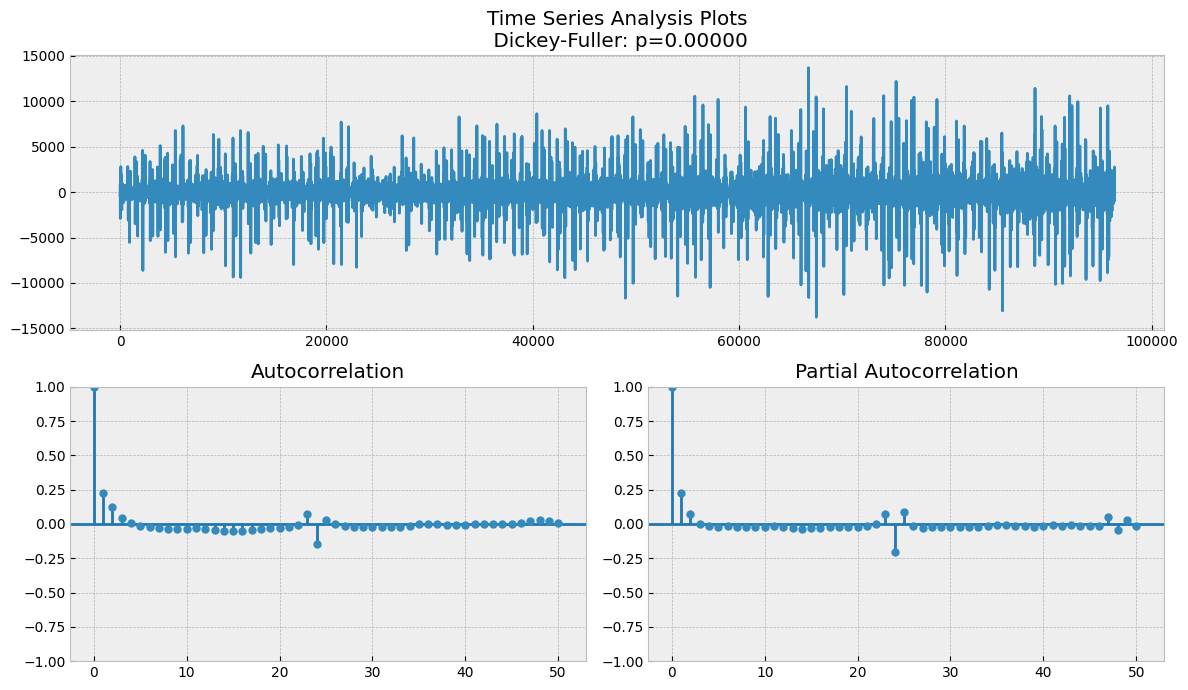

In [62]:
data_hourly_diff_1 = data_hourly["y"].diff().dropna()
test_stationarity(data_hourly_diff_1)
tsplot(data_hourly_diff_1)

Мы вновь получаем стационарный ряд, однако на диаграмме автокорреляции и частичной автокорреляции остаются незначительные пики, свидетельствующие о наличии сезонности (с лагом 1 и 24, т.е. час и сутки).

Визуализация временного ряда показывала широкий размах данных. Это может быть источником шума при моделировании. С целью снижения шумности данных выполним сглаживание временного ряда с помощью скользящего среднего. В данном случае окно сглаживания составляет 3 часа, при этом расчет среднего ведется с использованием двух предыдущих и текущего значения.

In [63]:
data_hourly['y'] = data_hourly['y'].rolling(window=3, center=False).mean()
data_hourly.dropna(inplace=True)
data_hourly['y'] = data_hourly['y'].astype(int)

In [64]:
data_hourly.head()

,ds,y
2,2011-01-01 02:00:00,5127
3,2011-01-01 03:00:00,5629
4,2011-01-01 04:00:00,6001
5,2011-01-01 05:00:00,6276
6,2011-01-01 06:00:00,6401


#### 2. Моделирование временного ряда с помощью библиотеки Prophet

Для моделирования временного ряда выбрана библиотека Prophet. Возможно, это не лучший вариант, поскольку данная модель чувствительна к выбросам данных, которые, очевидно, присутствуют в изучаемом датасете. Тем не менее, библиотека предоставляет широким набор инструментов для задания сезонности временного ряда. Возможно, подготовка данных и встроенные инструменты библиотеки позволят выполнить качественное прогнозирование.

Зададим диапазон прогнозирования. Это календарный код. Поскольку данные являются часовыми, то зададим диапазон прогнозирования как 24*365.

In [65]:
predictions = 24*365

В модели Prophet существует возможность добавления различных сезонностей, кроме стандартных недельной, месячной, годовой. Поэтому создадим ряд булевых признаков для последующего добавления сезонности в модель. В данном случае мы сгенерируем следующие признаки: сезоны (зима, лето, осень, весна (впоследствии исключена вследствие малого влияния на результаты)); цикл дня (ночь, утро, день, вечер); час в течение дня (от 0 до 24), день месяца (от 1 до 31).

In [66]:
data_hourly['is_winter'] = data_hourly['ds'].dt.month.isin([12, 1, 2])
#data_hourly['is_spring'] = data_hourly['ds'].dt.month.isin([3, 4, 5])
data_hourly['is_summer'] = data_hourly['ds'].dt.month.isin([6, 7, 8])
data_hourly['is_autumn'] = data_hourly['ds'].dt.month.isin([9, 10, 11])

data_hourly['is_night'] = data_hourly['ds'].dt.hour.isin(range(0, 6))
data_hourly['is_morning'] = data_hourly['ds'].dt.hour.isin(range(6, 12))
data_hourly['is_afternoon'] = data_hourly['ds'].dt.hour.isin(range(12, 18))
data_hourly['is_evening'] = data_hourly['ds'].dt.hour.isin(range(18, 24))

In [67]:
for h in range(24):
    data_hourly[f'is_hour_{h}'] = (data_hourly['ds'].dt.hour == h)

In [68]:
for day in range(1, 32):
   data_hourly[f'is_day_{day}'] = (data_hourly['ds'].dt.day == day)

In [69]:
data_hourly.head()

,ds,y,is_winter,is_summer,is_autumn,is_night,is_morning,is_afternoon,is_evening,is_hour_0,...,is_day_22,is_day_23,is_day_24,is_day_25,is_day_26,is_day_27,is_day_28,is_day_29,is_day_30,is_day_31
2,2011-01-01 02:00:00,5127,True,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,2011-01-01 03:00:00,5629,True,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,2011-01-01 04:00:00,6001,True,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,2011-01-01 05:00:00,6276,True,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,2011-01-01 06:00:00,6401,True,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Как уже упоминалось выше, наши данные имеют ненормальное распределение, поэтому в целях приведения к более нормальному виду, плюс снижения размаха выбросов выполним логарифмирование целевой переменной "y".

In [70]:
data_hourly['y'] = np.log1p(data_hourly['y'])
data_hourly.head()

,ds,y,is_winter,is_summer,is_autumn,is_night,is_morning,is_afternoon,is_evening,is_hour_0,...,is_day_22,is_day_23,is_day_24,is_day_25,is_day_26,is_day_27,is_day_28,is_day_29,is_day_30,is_day_31
2,2011-01-01 02:00:00,8.542471,True,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,2011-01-01 03:00:00,8.635865,True,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,2011-01-01 04:00:00,8.699848,True,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,2011-01-01 05:00:00,8.744647,True,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,2011-01-01 06:00:00,8.764366,True,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Зададим диапазон обучения модели

In [71]:
train_df = data_hourly[:-predictions]

Создадим модель Prophet. Добавим запланированные сезонности, после чего выполним обучение и предсказание на выбранный диапазон прогнозирования.

In [72]:
model_prophet = Prophet(
    yearly_seasonality=True,
    seasonality_mode='multiplicative',
    weekly_seasonality=False,
    seasonality_prior_scale=0.5,
    changepoint_prior_scale=0.1
    )

model_prophet.add_seasonality(name='daily', period=1, fourier_order=1, prior_scale=0.1)
#model_prophet.add_seasonality(name='quaternaly', period=90, fourier_order=1, prior_scale=0.5)
model_prophet.add_seasonality(name='winter_season', period=90, fourier_order=1, condition_name='is_winter', prior_scale=0.1)
#model_prophet.add_seasonality(name='spring_season', period=90, fourier_order=1, condition_name='is_spring', prior_scale=0.1)
model_prophet.add_seasonality(name='summer_season', period=90, fourier_order=1, condition_name='is_summer', prior_scale=0.1)
model_prophet.add_seasonality(name='autumn_season', period=90, fourier_order=1, condition_name='is_autumn', prior_scale=0.1)
model_prophet.add_seasonality(name='night_cycle', period=1, fourier_order=1, condition_name='is_night', prior_scale=0.1)
model_prophet.add_seasonality(name='morning_cycle', period=1, fourier_order=1, condition_name='is_morning', prior_scale=0.1)
model_prophet.add_seasonality(name='afternoon_cycle', period=1, fourier_order=1, condition_name='is_afternoon', prior_scale=0.1)
model_prophet.add_seasonality(name='evening_cycle', period=1, fourier_order=1, condition_name='is_evening', prior_scale=0.1)

for day in range(1, 32):
    model_prophet.add_seasonality(
        name=f'day_{day}',
        period=30.5,  # средняя длина месяца (~30.5 дней)
        fourier_order=1,
        condition_name=f'is_day_{day}'
    )

for h in range(24):
    model_prophet.add_seasonality(
        name=f'hour_{h}',
        period=24,  # сутки
        fourier_order=1,  # по одному синусу на каждый час
        condition_name=f'is_hour_{h}'
    )

model_prophet.fit(train_df)

future = model_prophet.make_future_dataframe(periods=predictions, freq='h')

future['is_winter'] = future['ds'].dt.month.isin([12, 1, 2])
#future['is_spring'] = future['ds'].dt.month.isin([3, 4, 5])
future['is_summer'] = future['ds'].dt.month.isin([6, 7, 8])
future['is_autumn'] = future['ds'].dt.month.isin([9, 10, 11])
future['is_night'] = future['ds'].dt.hour.isin(range(0, 6))
future['is_morning'] = future['ds'].dt.hour.isin(range(6, 12))
future['is_afternoon'] = future['ds'].dt.hour.isin(range(12, 18))
future['is_evening'] = future['ds'].dt.hour.isin(range(18, 24))

for day in range(1, 32):
    future[f'is_day_{day}'] = (future['ds'].dt.day == day)

for h in range(24):
    future[f'is_hour_{h}'] = (future['ds'].dt.hour == h)


forecast = model_prophet.predict(future)

forecast.tail()

21:11:58 - cmdstanpy - INFO - Chain [1] start processing
21:13:04 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,afternoon_cycle,afternoon_cycle_lower,afternoon_cycle_upper,autumn_season,...,winter_season,winter_season_lower,winter_season_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
96374,2021-12-30 02:00:00,7.447357,7.376737,10.228637,7.059689,7.850919,0.0,0.0,0.0,0.0,...,-0.005825,-0.005825,-0.005825,0.087470,0.087470,0.087470,0.0,0.0,0.0,8.800157
96375,2021-12-30 03:00:00,7.447356,7.292232,10.319799,7.059635,7.850978,0.0,0.0,0.0,0.0,...,-0.005801,-0.005801,-0.005801,0.087388,0.087388,0.087388,0.0,0.0,0.0,8.751069
96376,2021-12-30 04:00:00,7.447356,7.307170,10.175641,7.059582,7.851037,0.0,0.0,0.0,0.0,...,-0.005777,-0.005777,-0.005777,0.087304,0.087304,0.087304,0.0,0.0,0.0,8.696733
96377,2021-12-30 05:00:00,7.447355,7.144924,10.063682,7.059528,7.851096,0.0,0.0,0.0,0.0,...,-0.005753,-0.005753,-0.005753,0.087219,0.087219,0.087219,0.0,0.0,0.0,8.637220
96378,2021-12-30 06:00:00,7.447354,7.220553,10.192177,7.059474,7.851156,0.0,0.0,0.0,0.0,...,-0.005729,-0.005729,-0.005729,0.087133,0.087133,0.087133,0.0,0.0,0.0,8.693812


Поскольку моделирование временного ряда проводилось с использованием логарифмически преобразованных данных, то выполним обратную операцию и восстановим исходный формат данных.

In [73]:
forecast[['yhat', 'yhat_lower', 'yhat_upper']] = np.expm1(forecast[['yhat', 'yhat_lower', 'yhat_upper']])

In [74]:
data_hourly['y'] = np.expm1(data_hourly['y'])
data_hourly['y'] = data_hourly['y'].astype(int)
data_hourly.tail()

,ds,y,is_winter,is_summer,is_autumn,is_night,is_morning,is_afternoon,is_evening,is_hour_0,...,is_day_22,is_day_23,is_day_24,is_day_25,is_day_26,is_day_27,is_day_28,is_day_29,is_day_30,is_day_31
96387,2021-12-30 03:00:00,5824,True,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
96388,2021-12-30 04:00:00,6372,True,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
96389,2021-12-30 05:00:00,6988,True,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
96390,2021-12-30 06:00:00,7705,True,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False
96391,2021-12-30 07:00:00,8206,True,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False


Объединим данные из созданного датасета forecast и исходного датасета для удобства работы. Выделим данные из диапазона прогнозирования. Переменная y_true содержит истинные данные из диапазона прогнозирования, а y_pred - предсказанные данные.

In [75]:
merged = pd.merge(
    data_hourly[['ds', 'y']], 
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], 
    on='ds', 
    how='inner'
    )

y_true = merged['y'].iloc[-predictions:]
y_pred = merged['yhat'].iloc[-predictions:]

merged.tail()

,ds,y,yhat,yhat_lower,yhat_upper
96373,2021-12-30 02:00:00,5764,6634.285085,1597.365324,27683.754767
96374,2021-12-30 03:00:00,5824,6316.435291,1467.846135,30326.149046
96375,2021-12-30 04:00:00,6372,5982.331447,1489.951671,26254.780126
96376,2021-12-30 05:00:00,6988,5636.632617,1266.654626,23473.787778
96377,2021-12-30 06:00:00,7705,5964.878650,1366.245529,26692.549332


Выполним визуализацию прогноза и истинных данных

Mean absolute error 2532.19
Mean absolute percentage error 165.32%


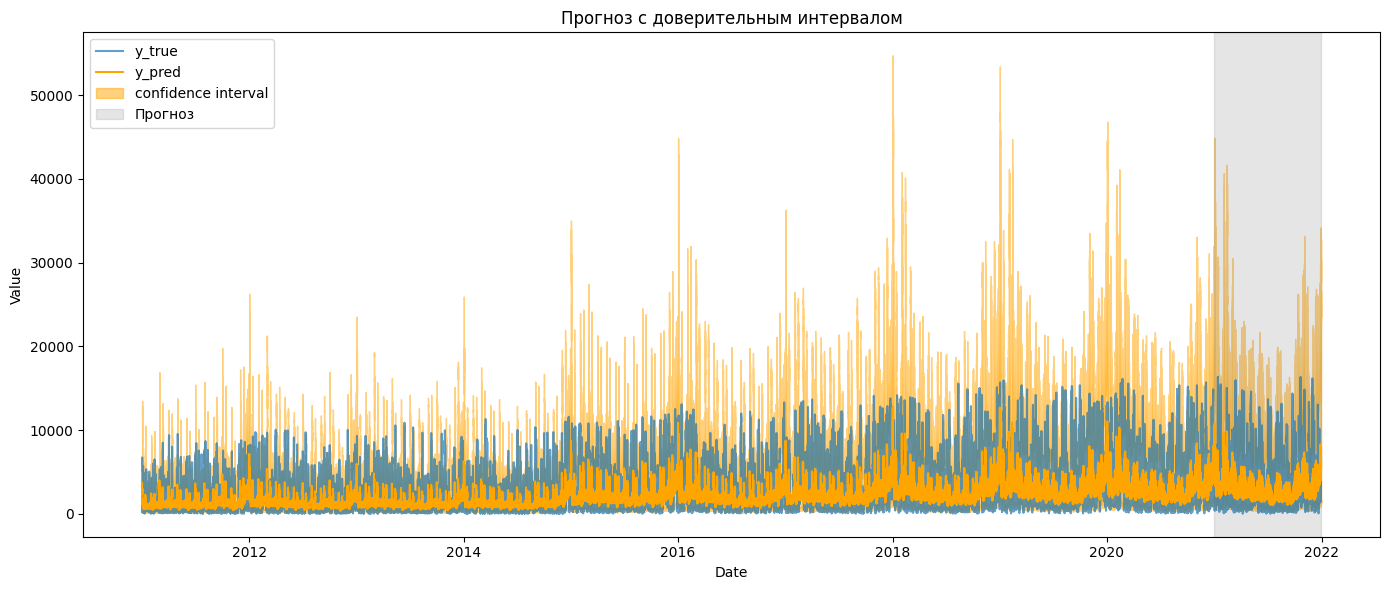

In [76]:
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred) * 100

print("Mean absolute error {0:.2f}".format(mae))
print("Mean absolute percentage error {0:.2f}%".format(mape))

plt.figure(figsize=(14, 6))

plt.plot(merged['ds'],
         merged['y'],
         label='y_true',
         alpha=0.7)

plt.plot(merged['ds'],
         merged['yhat'],
         label='y_pred',
         color='orange')

plt.fill_between(
    merged['ds'], 
    merged['yhat_lower'], 
    merged['yhat_upper'], 
    color='orange', 
    alpha=0.5, 
    label='confidence interval'
)

prediction_start = merged['ds'].iloc[-predictions]  # начальная дата прогноза
prediction_end = merged['ds'].iloc[-1]

plt.axvspan(prediction_start,
            prediction_end,
            color='gray',
            alpha=0.2,
            label='Прогноз')

plt.legend()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Прогноз с доверительным интервалом')
plt.tight_layout()

plt.show()

Отмечаем, что спрогнозированный временной ряд довольно неплохо описывает структуру оригинальных данных, однако он не улавливает их колебаний. Метрики качества прогнозирования плохие. Все-таки выполненная подготовка данных не позволила добиться того, чтобы модель Prophet осуществила точный прогноз.

Укрупним область прогноза для удобства наблюдения.

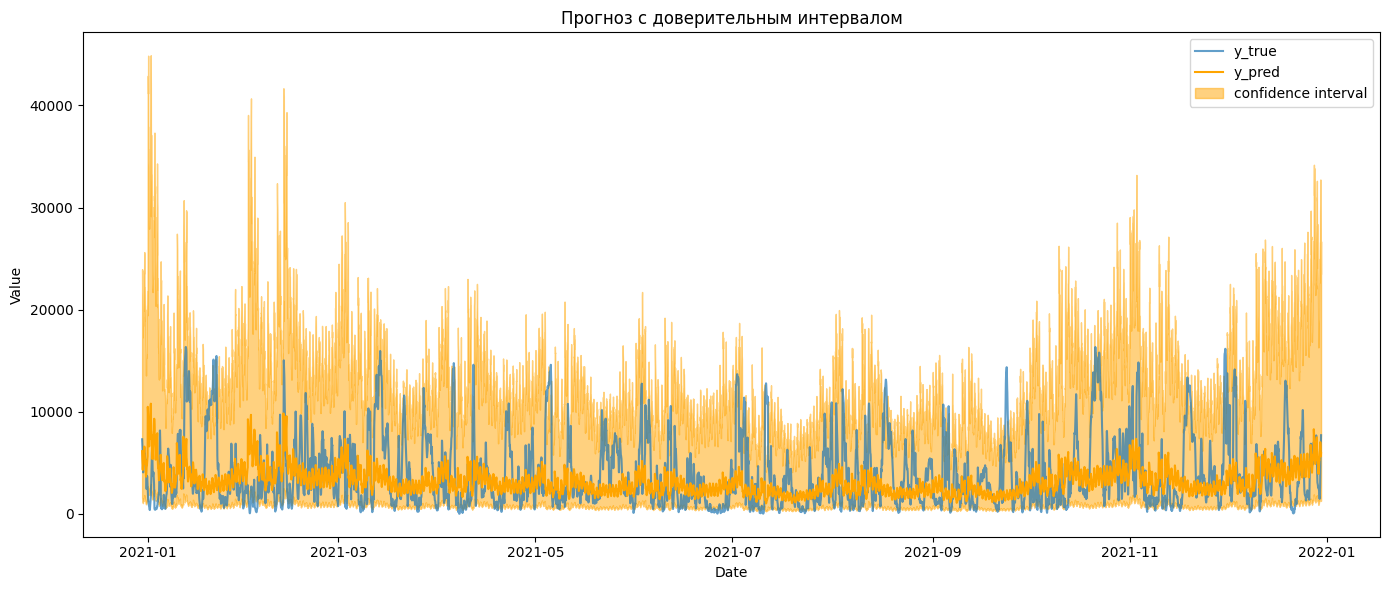

In [77]:
plt.figure(figsize=(14, 6))

plt.plot(merged['ds'][-predictions:], merged['y'][-predictions:], label='y_true', alpha=0.7)

plt.plot(merged['ds'][-predictions:], merged['yhat'][-predictions:], label='y_pred', color='orange')

plt.fill_between(
    merged['ds'][-predictions:], 
    merged['yhat_lower'][-predictions:], 
    merged['yhat_upper'][-predictions:], 
    color='orange', 
    alpha=0.5, 
    label='confidence interval'
)

plt.legend()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Прогноз с доверительным интервалом')
plt.tight_layout()

plt.show()

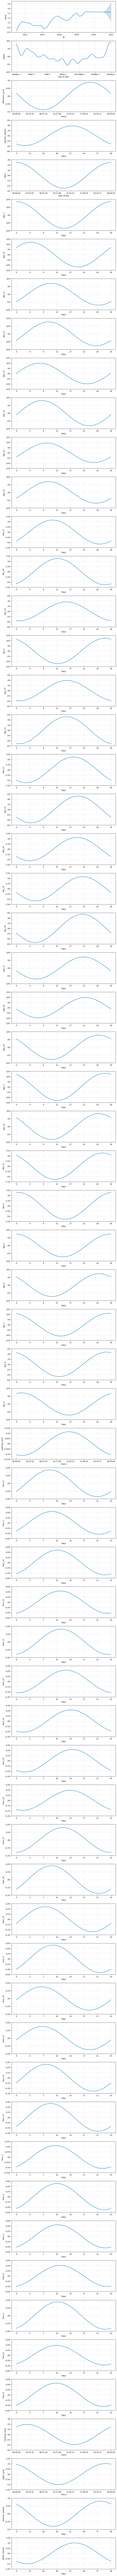

In [78]:
fig = model_prophet.plot_components(forecast)
plt.show()

Анализ отдельных компонент сезонности (булевых признаков) показывает, что в большинстве случае они оказывают незначительное влияние на сезонность (колебания в диапазоне 1 %) - циклы дня, сезоны, часы в течение дня.

#### 3. Моделирование временного ряда с помощью LightGBM

Поскольку для модели Prophet получены не удовлетворительные результаты, выполним прогнозирование с помощью модели LightGBM. Эта модель бустинга устойчива к выбросам, поэтому должна продемонстрировать более точные результаты прогнозирования.

Мы уже имеем практически готовые данные, подготовленные для модели Prophet. Они включают ряд булевых признаков (сезон, цикл дня, час в течение дня, а также день месяца).

In [79]:
data_hourly.head()

,ds,y,is_winter,is_summer,is_autumn,is_night,is_morning,is_afternoon,is_evening,is_hour_0,...,is_day_22,is_day_23,is_day_24,is_day_25,is_day_26,is_day_27,is_day_28,is_day_29,is_day_30,is_day_31
2,2011-01-01 02:00:00,5126,True,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,2011-01-01 03:00:00,5628,True,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,2011-01-01 04:00:00,6001,True,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,2011-01-01 05:00:00,6276,True,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,2011-01-01 06:00:00,6400,True,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Как и ранее для модели Prophet, выполним логарифмическое преобразование данных.

In [80]:
data_hourly['y_log'] = np.log1p(data_hourly['y'])

Также добавим еще несколько признаков, например, день в течение недели и месяц, после чего проведем one-hot кодирование.

In [81]:
data_hourly['dayofweek'] = data_hourly['ds'].dt.dayofweek
data_hourly['month'] = data_hourly['ds'].dt.month

In [82]:
data_hourly.tail()

,ds,y,is_winter,is_summer,is_autumn,is_night,is_morning,is_afternoon,is_evening,is_hour_0,...,is_day_25,is_day_26,is_day_27,is_day_28,is_day_29,is_day_30,is_day_31,y_log,dayofweek,month
96387,2021-12-30 03:00:00,5824,True,False,False,True,False,False,False,False,...,False,False,False,False,False,True,False,8.669914,3,12
96388,2021-12-30 04:00:00,6372,True,False,False,True,False,False,False,False,...,False,False,False,False,False,True,False,8.759826,3,12
96389,2021-12-30 05:00:00,6988,True,False,False,True,False,False,False,False,...,False,False,False,False,False,True,False,8.852093,3,12
96390,2021-12-30 06:00:00,7705,True,False,False,False,True,False,False,False,...,False,False,False,False,False,True,False,8.949755,3,12
96391,2021-12-30 07:00:00,8206,True,False,False,False,True,False,False,False,...,False,False,False,False,False,True,False,9.012743,3,12


In [83]:
dummies_month = pd.get_dummies(data_hourly['month'], prefix='month')
dummies_dayofweek = pd.get_dummies(data_hourly['dayofweek'], prefix='dayofweek')

data_hourly = pd.concat([data_hourly, dummies_month, dummies_dayofweek], axis=1)

In [84]:
data_hourly.drop(['month', 'dayofweek'], axis=1, inplace=True)

Модель LightGBM позволяет удобно работать с данными, сдвинутыми на несколько лагов. Это эффективный инструмент анализа временных рядов, однако в модели Prophet он реализован очень неудобно.

Добавим сдвиг данных на 1-25 лагов в изучаемый датасет. Часть данных придется удалить из-за наличия значений nan. Однако это данные из начала датасета, поэтому это не представляет проблемы.

In [85]:
for lag in range(1, 25):
    data_hourly[f'lag_{lag}'] = data_hourly['y_log'].shift(lag)

data = data_hourly.dropna().reset_index(drop=True)

In [86]:
data.tail()

,ds,y,is_winter,is_summer,is_autumn,is_night,is_morning,is_afternoon,is_evening,is_hour_0,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
96350,2021-12-30 03:00:00,5824,True,False,False,True,False,False,False,False,...,7.841493,7.890208,7.891331,7.862112,7.853216,7.896181,7.963112,7.981392,7.995980,8.035279
96351,2021-12-30 04:00:00,6372,True,False,False,True,False,False,False,False,...,7.790696,7.841493,7.890208,7.891331,7.862112,7.853216,7.896181,7.963112,7.981392,7.995980
96352,2021-12-30 05:00:00,6988,True,False,False,True,False,False,False,False,...,7.763446,7.790696,7.841493,7.890208,7.891331,7.862112,7.853216,7.896181,7.963112,7.981392
96353,2021-12-30 06:00:00,7705,True,False,False,False,True,False,False,False,...,7.752335,7.763446,7.790696,7.841493,7.890208,7.891331,7.862112,7.853216,7.896181,7.963112
96354,2021-12-30 07:00:00,8206,True,False,False,False,True,False,False,False,...,7.692113,7.752335,7.763446,7.790696,7.841493,7.890208,7.891331,7.862112,7.853216,7.896181


Выделим датасет с целевой переменной y и датасет с независимыми переменными Х.

In [87]:
cols_to_X = [col for col in data_hourly.columns if col not in ['ds', 'y', 'y_log']]
X = data[cols_to_X]
y = data['y_log']

Выделим датасеты для обучения и тестирования. В данном случае для тестирования мы отложими 10 % от датасета, что соответствует примерно 1 календарному году (поскольку датасет включает примерно 11-летний интервал данных). Проведем обучение.

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1, random_state=42)

model = LGBMRegressor(n_estimators=350, learning_rate=0.05)
model.fit(X_train, y_train)

y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)*100
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Absolute Percantage Error: {mape:.2f}%")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,009306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6282
[LightGBM] [Info] Number of data points in the train set: 86719, number of used features: 105
[LightGBM] [Info] Start training from score 7,499900
Mean Absolute Error: 197.46
Mean Absolute Percantage Error: 6.35%


Как видим, модель LightGBM демонстрирует отличные результаты в прогнозировании временного ряда. Прежде всего, это обусловлено использованием сдвига данных, что позволяет модели уловить зависимости между ними.

Визуализируем прогноз выполненный моделью. Как видим, прогноз практически полностью повторяет оригинальные данные.

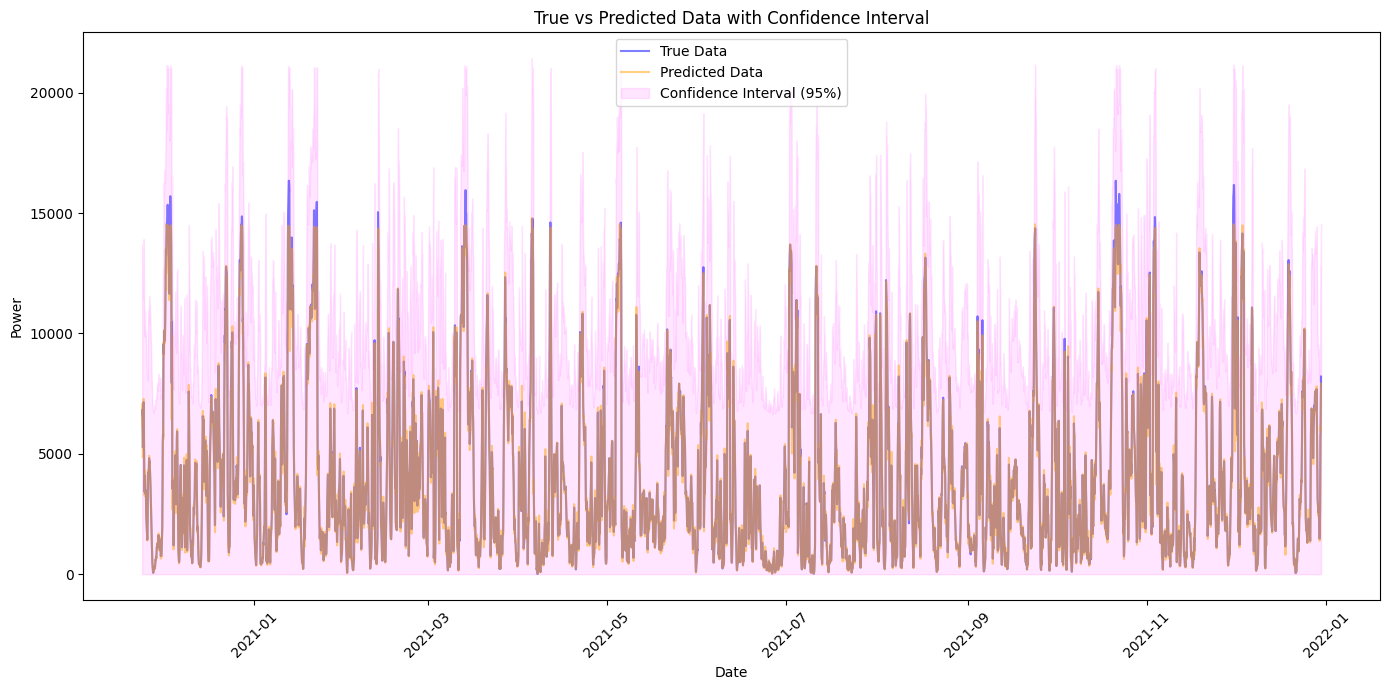

In [89]:
y_pred_std = np.std(y_pred)

# Доверительный интервал (например, для 95%)
lower_bound = 0
upper_bound = y_pred + 1.96 * y_pred_std

# Визуализация данных
plt.figure(figsize=(14, 7))

plt.plot(data['ds'][-len(y_test):],
         y_true, label='True Data',
         color='blue',
         alpha=0.5)

plt.plot(data['ds'][-len(y_test):],
         y_pred, label='Predicted Data',
         color='orange',
         alpha=0.5)

plt.fill_between(data['ds'][-len(y_test):],
                 lower_bound, upper_bound,
                 color='magenta',
                 alpha=0.1,
                 label='Confidence Interval (95%)')

plt.legend()
plt.title('True vs Predicted Data with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Power')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

### Заключение

Проведено моделирование временного ряда. Для моделирования применялись две модели, Prophet и модель градиентного бустинга LightGBM. Несмотря на широкие возможности, которыми обладает библиотека Prophet для моделирования временных рядов, особенно для задания сезонности, не удалось добиться точного прогноза для имеющегося временного ряда. Возможно, причина в больших колебаниях данных и отсутствии строгой структуры (сезонности, тренда). Модель LightGBM при использовании сдвига данных позволила добавиться очень хороших результатов.